In [25]:
from keras import layers
from keras import models

from keras.datasets import boston_housing

### Load the data

In [2]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

57344/57026 [==============================] - 0s 1us/step


In [3]:
train_data.shape

(404, 13)

In [4]:
test_data.shape

(102, 13)

In [5]:
train_targets.shape

(404,)

In [6]:
test_targets.shape

(102,)

In [11]:
train_targets[:10]

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4])

### Prepare the data

In [16]:
mean = train_data.mean(axis=0)

In [19]:
train_data -= mean

In [20]:
std = train_data.std(axis=0)

In [21]:
train_data /= std

In [24]:
test_data -= mean
test_data /= std

### Build the network

In [26]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model


### Train the network 

In [29]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('fold ', i)
    val_data = train_data[i * num_val_samples: (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i+1) * num_val_samples]
    
    partail_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i+1)*num_val_samples:]], 
        axis=0)
    
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    
    model = build_model()
    model.fit(partail_train_data, partial_train_targets,
             epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

fold  0
fold  1
fold  2
fold  3


In [30]:
all_scores

[2.097097171415197, 2.222375815457637, 2.894578260950523, 2.412014556403207]

In [31]:
np.mean(all_scores)

2.406516451056641

In [33]:
num_epochs = 100
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]    
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(                                     
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    model = build_model()                                                    
    history = model.fit(partial_train_data, partial_train_targets,           
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [45]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

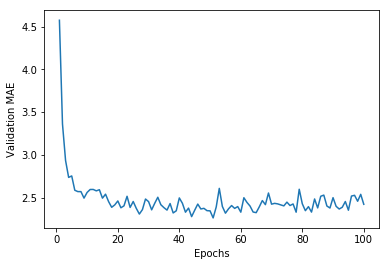

In [46]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

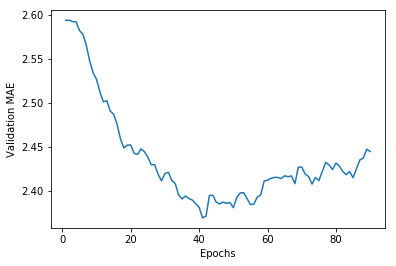

In [49]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [50]:
model = build_model()                                                     
model.fit(train_data, train_targets,                                      
          epochs=40, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 802us/step


In [53]:
test_mse_score

19.07986659629672

In [54]:
test_mae_score * 1000

2778.518078373928